# Bootstrapping Simple Linear Regression

We can use the bootstrap method to get regression models. Bootstrapping a regression model gives insight into how variable the model parameters are. It is helpful to know how much random variation in regression coefficients is due to small data values change. 

It is possible to bootstrap almost any regression model, but it can be computationally intensive.

In [1]:
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid")

## The Data

In [2]:
df = pd.read_csv('salary_data.csv')
print(df.shape)
df.head()

(30, 2)


,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


## The Model

In [3]:
import statsmodels.api as sm

In [4]:
x = np.array(df.YearsExperience)
y = np.array(df.Salary)

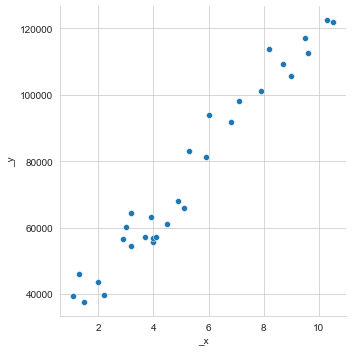

In [5]:
sns.relplot(data=df, x=x, y=y);  

In [6]:
Xc = sm.add_constant(x)

In [7]:
mod = sm.OLS(y, Xc)

In [8]:
res = mod.fit()

In [9]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     622.5
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           1.14e-20
Time:                        17:40:59   Log-Likelihood:                -301.44
No. Observations:                  30   AIC:                             606.9
Df Residuals:                      28   BIC:                             609.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.579e+04   2273.053     11.347      0.000    2.11e+04    3.04e+04
x1          9449.9623    378.755     24.950      0.000    8674.119    1.02e+04
==============================================================================
Omnibus:                        2.140   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.343   Jarque-Bera (JB):                1.569
Skew:                           0.363   Prob(JB):                        0.456
Kurtosis:                       2.147   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
print('Coefficient of determination: %.3f' %(res.rsquared))

Coefficient of determination: 0.957


In [11]:
intercept = res.params[0] 
slope = res.params[1] 

In [12]:
eq = 'Model: ' + str(np.round(slope,2)) +' * YearsExperience + ' + str(np.round(intercept,2))
eq

'Model: 9449.96 * YearsExperience + 25792.2'

In [13]:
df['predict'] = res.predict()
df.head(3)

,YearsExperience,Salary,predict
0,1.1,39343,36187.158752
1,1.3,46205,38077.151217
2,1.5,37731,39967.143681


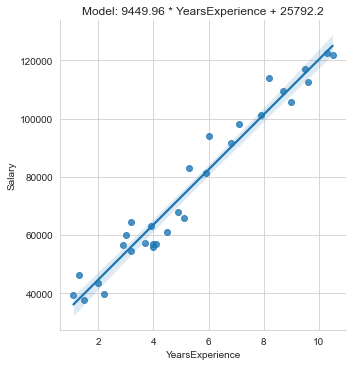

In [14]:
sns.lmplot(data=df, x='YearsExperience', y='Salary')
ax = plt.gca()
ax.set_title(eq);

## Bootstrapping Method

Let's perform a parametric resampling.

We are going to resample WITH replacement each row.

In [15]:
def bootSimpleReg(x, y, num_samples=10000, sample_size=100):
    '''
    It returns two list with the simple regression sample distribution: slopes and intercepts.
    '''
    slopeSD  = np.full((num_samples), 0.)
    intercSD = np.full((num_samples), 0.)
    x = np.array(x)
    y = np.array(y)
    idx = np.array(range(len(x)))
    for k in range(num_samples):
        index = np.random.choice(idx, replace=True, size=sample_size)
        xi = x[index]
        yi = y[index]
        xic = sm.add_constant(xi)
        modeli = sm.OLS(yi, xic)
        resi   = modeli.fit()
        slopeSD[k] = resi.params[1]
        intercSD[k]= resi.params[0]
    return(slopeSD, intercSD)  

In [16]:
slopeSD, intercSD = bootSimpleReg(x, y, num_samples=10000, sample_size=20)

Let's graph the results.

In [17]:
def plotBootSimpleReg(x, y, slopeSD, intercSD):
    '''
    Plot the regression model (red) and the bootstrap regressions 
    '''
    x = np.array(x)
    y = np.array(y)
    xc = sm.add_constant(x)
    model = sm.OLS(y,xc)    #defining the model
    res = model.fit()       #fitting the model
    xi = np.linspace(x.min(), x.max(), 100)
    for i in range(len(slopeSD)):
        yi = slopeSD[i] * xi + intercSD[i]
        plt.plot(xi, yi, color='gray', alpha=0.2)
    plt.plot(x, res.predict(), linewidth=2, color='darkred')
    plt.scatter(x, y, color='darkred', s=20)

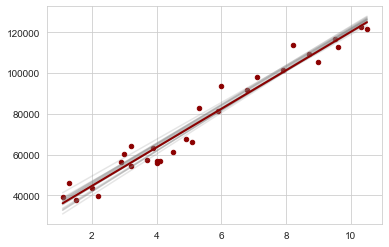

In [18]:
# Plotting the first 20 models
plotBootSimpleReg(x, y, slopeSD[:20], intercSD[:20])

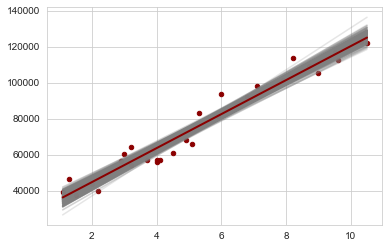

In [19]:
# Plotting 500 models
plotBootSimpleReg(x, y, slopeSD[:500], intercSD[:500])

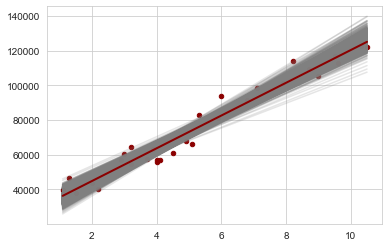

In [20]:
# Plotting 10000 models
plotBootSimpleReg(x, y, slopeSD, intercSD)

The bands are around the center because most data are near the center than at the edges.

Let us plot the sample distribution for slope and interception.

In [21]:
def plotSampleDistribution(sampDist, title='Sample Distribution'):
    '''
    It plots the sample distribution
    '''
    sns.kdeplot(sampDist, shade=True).set(title=title)

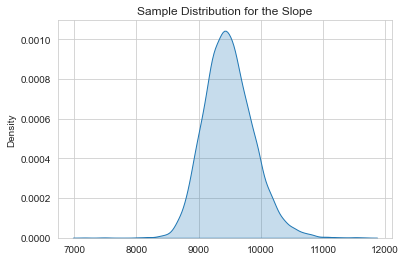

In [22]:
plotSampleDistribution(slopeSD, title='Sample Distribution for the Slope')

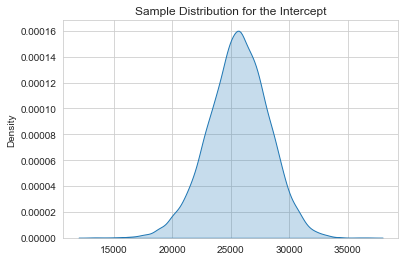

In [23]:
plotSampleDistribution(intercSD, title='Sample Distribution for the Intercept')

### Bootstrap Hypothesis Test for slope and intercept

Let's use the `getpValue` and `hyp_test` functions we already know.

In [24]:
def getpValue(sample_distribution, obs_value, alternative='two-sided'):
    '''
    It returns the pValue.
    sample_distribution: the sample distribution
    obs_value:           observed value 
    alpha:               significance level
    alternative:         one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        if obs_value < np.mean(sample_distribution): 
            p_val = 2*ecdf(obs_value)
        else: 
            p_val = 2*(1-ecdf(obs_value)) 
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [25]:
def hyp_test(sampl_value, sampl_distribution, alpha=0.05, alternative='two-sided'):
    '''
    sampl_value:        observed value calculated from the sample
    sampl_distribution: sample distribution calculated from the sample
    alpha:              significance level
    alternative:        one of the three values: 'two-sided', 'smaller', and 'larger'
    '''
    sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
    print('--- Bootstrap Hypothesis Test ---')
    sns.kdeplot(x=sampl_distribution, color='lightskyblue', shade=True, alpha=0.4)  # plotting the sample distribution
    plt.axvline(x=sampl_value, ymin=0, ymax= 0.03, color='black', linewidth=6)      # plotting the statistic 
    plt.title('Sampling Distribution')
    p_val = getpValue(sampl_distribution, sampl_value, alternative)
    if alternative=='two-sided':        # plotting the graph with two critical regions
        cv1 = np.round(np.percentile(sampl_distribution, (alpha/2)*100),2)          # left critical value    
        cv2 = np.round(np.percentile(sampl_distribution, 100-(alpha/2)*100),2)      # right critical value    
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    elif alternative=='smaller':        # plotting the graph with left critical region
        cv1 = np.round(np.percentile(sampl_distribution, alpha*100),2)              # left critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    else:                               # plotting the graph with right critical region
        cv2 = np.round(np.percentile(sampl_distribution, 100-alpha*100),2)          # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('Observed Value = %.2f\tp-value = %.4f' %(sampl_value, p_val))  

We are interested in determining whether the model's parameters are significantly different from 0.

--- Bootstrap Hypothesis Test ---
Observed Value = 0.00	p-value = 0.0000


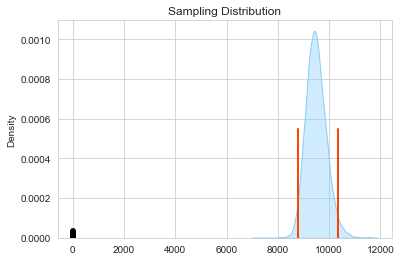

In [26]:
# Bootstrap Hypothesis Test for Slope
hyp_test(0, slopeSD)

Since the p-value is less than our significance level of .05, we reject the null hypothesis. The slope coefficient is significant!

We also want to know whether the intercept is significantly different from 0 or not.

--- Bootstrap Hypothesis Test ---
Observed Value = 0.00	p-value = 0.0000


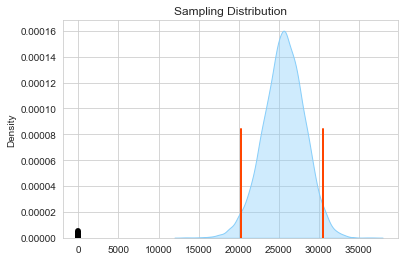

In [27]:
# Bootstrap Hypothesis Test for Intercept
hyp_test(0, intercSD)

The p-value < 0.05, therefore the intercept is significant! 

Let us apply a different type of bootstrapping, called non-parametric bootstrapping, whereby we use bootstrapping on the residuals and not the parameter itself.

## Non-parametric Bootstrapping

The idea here is to work with the residuals. Remember the errors or residuals are independent and identically distributed (IID) among our data.

In [28]:
df.head(3)

,YearsExperience,Salary,predict
0,1.1,39343,36187.158752
1,1.3,46205,38077.151217
2,1.5,37731,39967.143681


In [29]:
df['resids'] = res.resid
df.head(3)

,YearsExperience,Salary,predict,resids
0,1.1,39343,36187.158752,3155.841248
1,1.3,46205,38077.151217,8127.848783
2,1.5,37731,39967.143681,-2236.143681


Now we generate `num_samples` new sets of data by sampling the residuals WITH replacement and adding them to the fitted values.

In [30]:
def NPbootSimpleReg(x, y, num_samples=10000):
    '''
    It returns two list with the simple regression sample distribution: slopes and intercepts.
    '''
    slopeSD = np.full((num_samples), 0.)
    intercSD = np.full((num_samples), 0.)
    x = np.array(x)
    y = np.array(y)
    xc = sm.add_constant(x)
    model = sm.OLS(y,xc)    # defining the model
    res = model.fit()       # fitting the model
    yPred = res.predict()   # predicted values
    resids = res.resid      # getting the residuals
    sample_size = len(resids)
    for i in range(num_samples):
        # create a sampling of the residuals with replacement
        boot_resids = np.random.choice(resids, replace=True, size=sample_size)
        newY = [yPredi + residi for yPredi, residi in zip(yPred, boot_resids)]
        modeli = sm.OLS(newY, xc)
        resi = modeli.fit()
        slopeSD[i]  = resi.params[1]
        intercSD[i] = resi.params[0]
    return(slopeSD, intercSD)  

In [31]:
slopeSD2, intercSD2 = NPbootSimpleReg(x, y, num_samples=10000)

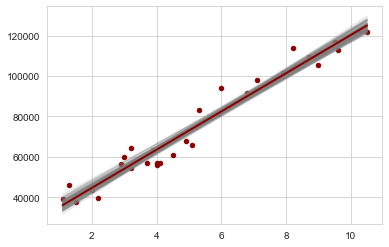

In [32]:
# Plotting the first 100 models
plotBootSimpleReg(x, y, slopeSD2[:100], intercSD2[:100])

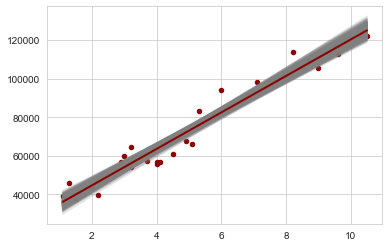

In [33]:
# Plotting 1000 models
plotBootSimpleReg(x, y, slopeSD2[:1000], intercSD2[:1000])

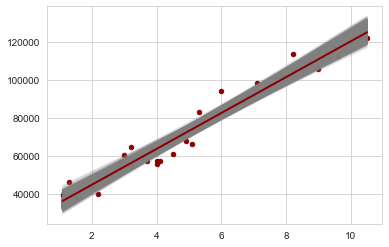

In [34]:
# Plotting all models
plotBootSimpleReg(x, y, slopeSD2, intercSD2)

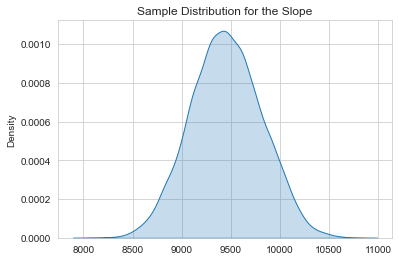

In [35]:
plotSampleDistribution(slopeSD2, title='Sample Distribution for the Slope')

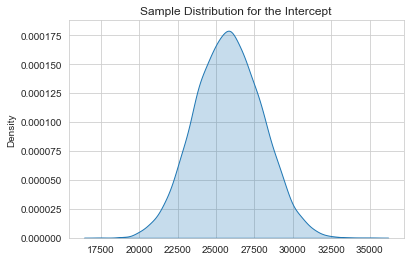

In [36]:
plotSampleDistribution(intercSD2, title='Sample Distribution for the Intercept')

--- Bootstrap Hypothesis Test ---
Observed Value = 0.00	p-value = 0.0000


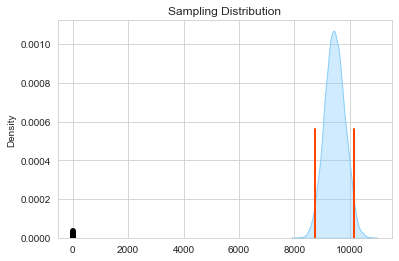

In [37]:
# Bootstrap Hypothesis Test for Slope 
hyp_test(0, slopeSD2)

--- Bootstrap Hypothesis Test ---
Observed Value = 0.00	p-value = 0.0000


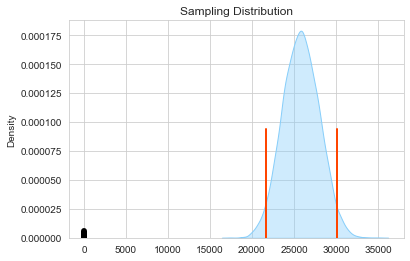

In [38]:
# Bootstrap Hypothesis Test for Intercept
hyp_test(0, intercSD2)

References:
- https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9
- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc. chapter 4.